In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt # for plotting
%matplotlib inline

In [5]:
# read in all the words
words = open('names.txt', 'r').read().split('\n')
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32033

In [7]:
# Build a vocabulary of charactrs and mapping to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {ch: i + 1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [8]:
# Build the dataset
block_size = 3 # Context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size # 0 is the index of '.'
        for ch in w + ".": # add stop token
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g) 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size) ** 0.5)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# Batch Norm Parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [11]:
# Same optimization as last time around 
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)

    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # Concatenation of the vectors

    # Linear layer 
    hpreact = embcat @ W1

    # Batch Norm Layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 1e-5) + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    

    # Non-Linearity 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # Output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        if p.grad is not None:
            p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0198
 190000/ 200000: 2.1707


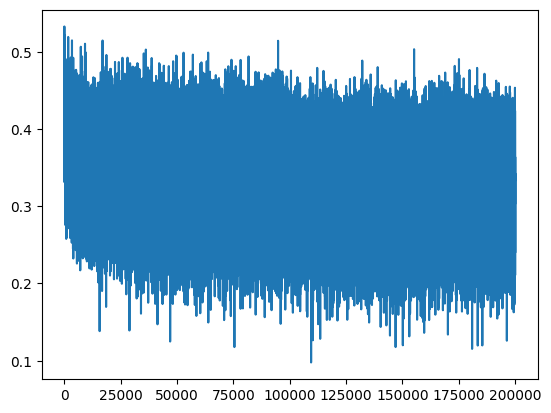

In [12]:
plt.plot(lossi)

In [13]:
# Calibrate the batch norm at the end of training 

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1

    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [14]:
@torch.no_grad() # This decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056840419769287


In [15]:
# Summary + pytorchifying the code

In [19]:
# Let's train a deeper network
# The classes we create here are the same API as PyTorch's nn.Module

class Linear:

    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features), generator=g) / in_features**0.5
        self.bias = torch.zeros(out_features) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters (trained with backprpop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / (xvar + self.eps).sqrt() # Normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out 
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out 

    def parameters(self):
        return []

n_embd = 10 # The dimensionality of the character embedding vectors
n_hidden = 100 # The number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # For reproduciblity

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 # 5 / 3
    

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    

47024


In [21]:
# same optimization as last time

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb) # Loss function

    # backward pass 
    for layer in layers:
        layer.out.retain_grad() # After_debug: would take out retain_graph
    
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i > 1000:
        break

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 0.03%
layer 5 (      Tanh): mean +0.01, std 0.65, saturated: 0.02%
layer 8 (      Tanh): mean +0.00, std 0.65, saturated: 0.02%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 0.02%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 0.01%


Text(0.5, 1.0, 'Activation Distribution')

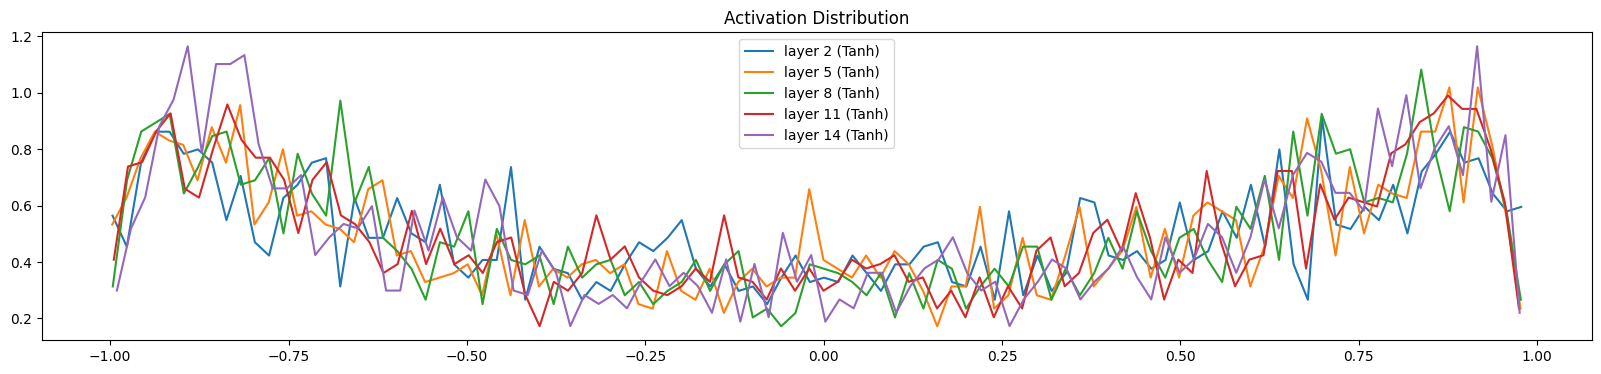

In [24]:
# Visualize histogram 
plt.figure(figsize=(20, 4)) # width and height of the plot 
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean().item(), t.std().item(), (torch.abs(t) > 0.97).float().mean().item()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation Distribution')

layer 2 (      Tanh): mean +0.000000, std 2.518574e-03
layer 5 (      Tanh): mean +0.000000, std 2.206680e-03
layer 8 (      Tanh): mean +0.000000, std 2.106731e-03
layer 11 (      Tanh): mean +0.000000, std 1.970895e-03
layer 14 (      Tanh): mean -0.000000, std 1.995119e-03


Text(0.5, 1.0, 'Gradient Distribution')

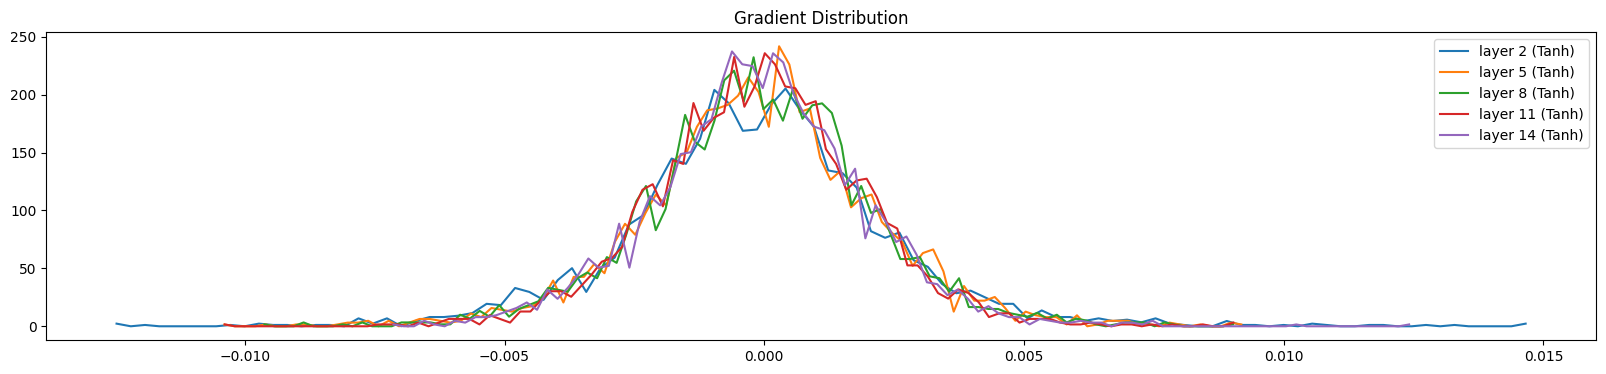

In [25]:
# visualise histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean().item(), t.std().item()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient Distribution')


weight   (27, 10) | mean -0.000000 | std 6.911687e-03 | grad:data ratio 6.904874e-03
weight  (30, 100) | mean +0.000014 | std 8.957455e-03 | grad:data ratio 4.731229e-02
weight (100, 100) | mean -0.000063 | std 6.635657e-03 | grad:data ratio 6.478988e-02
weight (100, 100) | mean +0.000155 | std 5.761066e-03 | grad:data ratio 5.612596e-02
weight (100, 100) | mean -0.000043 | std 5.538549e-03 | grad:data ratio 5.431695e-02
weight (100, 100) | mean +0.000013 | std 5.438007e-03 | grad:data ratio 5.340067e-02
weight  (100, 27) | mean +0.000018 | std 1.165237e-02 | grad:data ratio 1.117658e-01


Text(0.5, 1.0, 'Gradient Distribution')

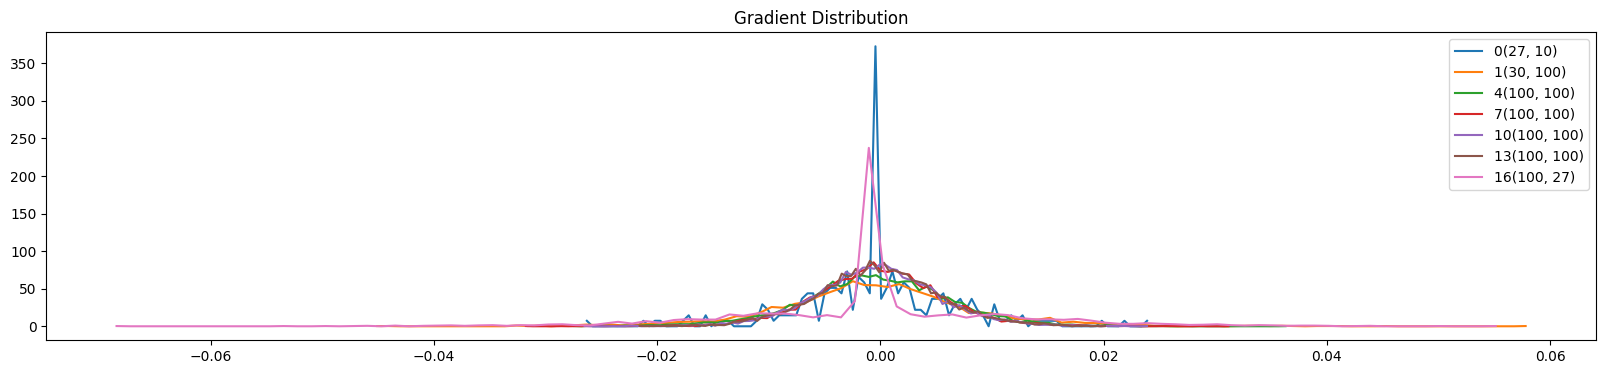

In [26]:
# Visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i}{tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution')


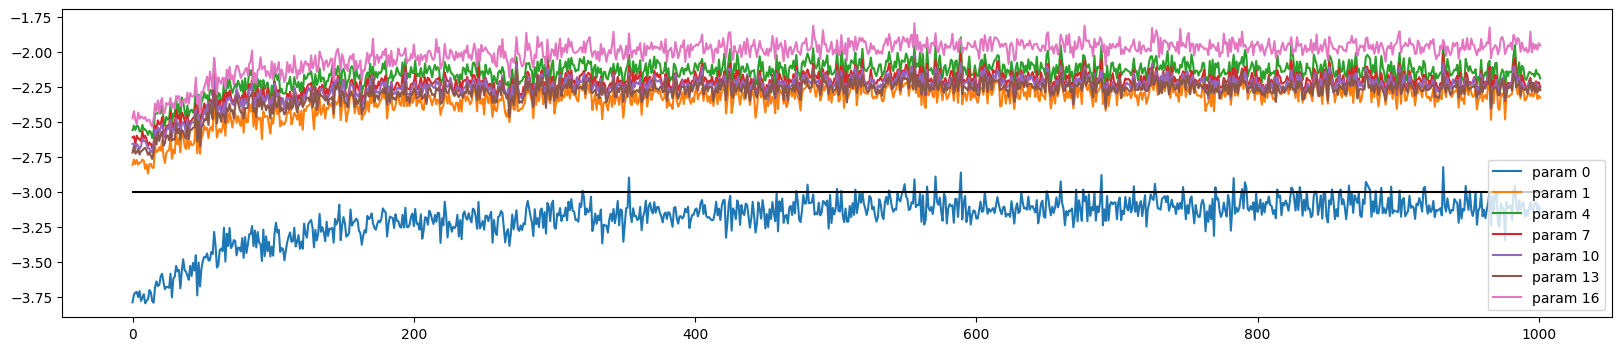

In [27]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)

In [30]:
@torch.no_grad() # This decorator disables gradient tracking 
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev), 
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layer into eval mode
for layer in layers:
    layer.training = False

split_loss('train')
split_loss('val')


train 2.3958914279937744
val 2.393686294555664


In [32]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # Initialize with all ...
    while True:
        # forward pass the neural net 
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        
        logits = x
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))


carpah.
qarlileif.
jmrix.
thty.
sacansa.
jazhnte.
dpn.
arciigqeiu.
ramara.
chaiiv.
kalein.
dhlm.
jocn.
qenjths.
lilea.
jadbq.
wazerogdearyxix.
kae.
pirran.
ed.


In [33]:
# Bonus content, not in the lecture

In [34]:
# BatchNorm forward pass as a widget

In [37]:
!pip install ipywidgets
!pip install scipy

You should consider upgrading via the '/Users/jayjoshi/Desktop/makemore/.env/bin/python3 -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 20.8 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/Users/jayjoshi/Desktop/makemore/.env/bin/python3 -m pip install --upgrade pip' command.


In [38]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

In [39]:
def normshow(x0):

    g = torch.Generator().manual_seed(2147483647)
    x = torch.randn(5, generator=g) * 5
    x[0] = x0
    mu = x.mean()
    sig = x.std()
    y = (x - mu) / sig

    plt.figure(figsize=(10, 5))
    # plot 0 
    plt.plot([-6, -6], [0, 0], 'k')

    # plot the mean and std
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')

    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')

    # plot the input and output values
    plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
    plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
    plt.xlim(-6, 6)

    # title
    plt.title('input mu %.2f std %.2f' %(mu, sig))

    interact(normshow, x0=(-30, 30, 0.5))

In [40]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000, 1), requires_grad=True, generator=g)
b = torch.randn((1000, 1000), requires_grad=True, generator=g)
c = b @ a

loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()

print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())

print('----')

print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())
print('c grad std:', c.grad.std().item())


a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
----
a grad std: 30.8818302154541
b grad std: 0.9666601419448853
c grad std: 0.9782556295394897


In [41]:
# Linear + BatchNorm: activation statistics of forward and backward pass
g = torch.Generator().manual_seed(2147483647)

n = 1000
inp = torch.randn(n, requires_grad=True, generator=g)   
w = torch.randn((n, n), requires_grad=True, generator=g)
x = w @ inp

# bn layer
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / (xvar + 1e-5).sqrt()

loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std:', inp.std().item())
print('w std:', w.std().item())
print('x std:', x.std().item())
print('out std:', out.std().item())

print('----')

print('inp grad std:', inp.grad.std().item())
print('w grad std:', w.grad.std().item())
print('x grad std:', x.grad.std().item())
print('out grad std:', out.grad.std().item())



inp std: 0.9875972270965576
w std: 1.0006722211837769
x std: 31.01241683959961
out std: 1.0
----
inp grad std: 0.9953053593635559
w grad std: 0.031169468536973
x grad std: 0.031543977558612823
out grad std: 0.9782556295394897
